In [20]:
import os
from dataclasses import dataclass
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data import (
    DataLoader, 
    Dataset, 
    ConcatDataset, 
    random_split
)

import matplotlib.pyplot as plt

#import UNet
from dataset import EvMaskDataset
from utils.manager import RenderManager

In [2]:
#Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device == "cuda:0": torch.cuda.set_device()

### Params Dataclass

In [9]:
@dataclass
class Params:
    
    #Dataset Params
    train_dir: str = "data/renders/train"
    
    #Image Params
    img_size: tuple = (128, 128)
    
    #Training Params
    optimizer = optim.RMSprop #optim.Adam
    batch_size: int = 1
    epochs: int = 5
    learning_rate: float = .0001
    val_split: float = .2

### Dataset

In [10]:
class EvMaskDataset(Dataset):
    
    def __init__(self, 
                 dir_num: int,
                 image_params: Params,
                 transforms: list = []):
        
        self.img_size = image_params.img_size
        self.transforms = transforms
        self.render_manager = RenderManager.from_directory(
            dir_num = dir_num,
            render_folder = Params.train_dir
        )
 
    def __len__(self):
        return len(self.render_manager)
    
    def preprocess(self, img: Image):
        """Resize and normalize the images to range 0, 1
        """
        img = img.resize(self.img_size)
        
        img_np = np.array(img)
        
        if len(img_np.shape) == 2:
            img_np = np.expand_dims(img_np, axis=2)

        # HWC to CHW
        img_trans = img_np.transpose((2, 0, 1))
        if img_trans.max() > 1:
            img_trans = img_trans / 255
        
        return img_trans
    
    def __getitem__(self, index: int):
        
        mask = self.render_manager.get_image("silhouette", index)
        
        event_frame = self.render_manager.get_event_frame(index)
        
        assert mask.size == event_frame.size, \
            "Mask and event frame must be same size"
        
        mask = torch.from_numpy(self.preprocess(mask)).type(torch.FloatTensor)
        event_frame = torch.from_numpy(self.preprocess(event_frame)).type(torch.FloatTensor)
        
        return event_frame, mask
           

### Evaluation

In [11]:
from losses import DiceCoeffLoss

def eval_seg_net(net, loader):
    loss = 0
    for X, y in loader:
        X = Variable(X).cuda()
        y = Variable(y).cuda()
        X = X.to(device=device, dtype=torch.float)
        y = y.to(device=device, dtype=torch.float)
        with torch.no_grad():
            out = net(X)
        loss += DiceCoeffLoss().forward(out, y)
    loss = loss / len(loader)
    return loss

In [12]:
#Start by first loading the net
unet = UNet(
    n_channels = 1, 
    n_classes = 1, 
    bilinear=False
).to(device=device)

#Create Train and Val DataLoaders
datasets = [EvMaskDataset(dir_num + 1, Params) for dir_num in range(len(os.listdir(Params.train_dir)) - 1)]
dataset = ConcatDataset(datasets)

val_size = int(len(dataset) * Params.val_split)
train_size = len(dataset) - val_size
train, val = random_split(dataset, (train_size, val_size))

train_loader = DataLoader(
    train,
    batch_size = Params.batch_size,
    shuffle = True,
    num_workers = 1,
    drop_last = True
)
val_loader = DataLoader(
    val,
    batch_size = Params.batch_size,
    shuffle = False,
    num_workers = 1,
    drop_last = True
)

optimizer = Params.optimizer(
    unet.parameters(),
    lr = Params.learning_rate,
    weight_decay = 1e-8,
    momentum = 0.9
)

#Or Maybe just use a cross entropy loss - need to eval this
if unet.n_classes > 1:
    criterion = nn.CrossEntropyLoss()
else:
    criterion = nn.BCEWithLogitsLoss()


In [13]:
torch.cuda.memory_allocated()

378562048

### Training Loop

In [14]:
iters = []
train_losses = []
val_losses = []

step = 0
min_loss = np.inf

unet.train()
for epoch in range(Params.epochs):
    for i, (X, y) in enumerate(train_loader):
        X = Variable(X).cuda()
        y = Variable(y).cuda()
        
        #Casting variables to float
        X = X.to(device=device, dtype=torch.float)
        y = y.to(device=device, dtype=torch.float)
        #print(X.shape)
        #print(y.shape)
        output = unet(X)
        loss = criterion(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            iters.append(i)
            train_losses.append(loss)
            
            unet.eval()
            val_loss = eval_seg_net(unet, val_loader)
            unet.train()
            val_losses.append(val_loss)
             

KeyboardInterrupt: 

In [15]:
torch.save({
    'epoch': epoch+1,
    'model': unet.state_dict(),
    'optimizer': optimizer.state_dict(),
    'losses': {
        'train': train_losses,
        'eval': val_losses
        }
    }, 'unet_checkpoint.pth')

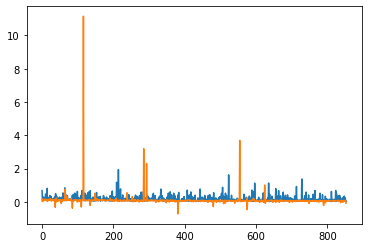

In [21]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

In [ ]:
import cv2
event = cv2.imread("data/renders/train/001-bottle_square_2020-09-10T09:14:24/events/0_event.png")
print(event.shape)
c = cv2.cvtColor(event, cv2.COLOR_BGR2GRAY)
if len(c.shape) == 2:
    c = np.expand_dims(c, axis=2)
c.shape

img = Image.open("data/renders/train/001-bottle_square_2020-09-10T09:14:24/events/0_event.png").convert('L')
img.size